In [14]:
import numpy as np
import random
from collections import defaultdict
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
from datetime import datetime
from tqdm import tqdm
import logging
from pathlib import Path

# Add the `src` folder to the Python path
sys.path.append(os.path.join(os.path.abspath('..'), 'src'))
import environment_gym

In [15]:
# TD class with states represented with integers
class TemporalDifference:
    def __init__(self, oiv = 0, alpha=0.1, epsilon=0.1, lambd=0.9, gamma=0.9):
        """
        Args:
        - lanes (int): Number of lanes (default is 5).
        - initial_distance (int): The distance from destination.
        - alpha (float): learning rate, between 0 and 1
        - epsilon (float): exploration rate between, 0 and 1
        - lambd (float): contribution of past rewards, between 0 and 1
        - gamma (float): discount factor, between 0 and 1
        - oiv (int/float): optimistic initial value
        """
        super().__init__()
        self.Env = environment_gym.TrafficEnvironment()
        self.alpha = alpha
        self.epsilon = epsilon
        self.lambd = lambd
        self.gamma = gamma
        self.oiv = oiv

        # Action space: 3 actions (0: move left, 1: stay, 2: move right)
        self.action_space = 3

        # use nested dictionaries for Q, E.
        # {state: [s_a1, s_a2, s_a3]}
        self.Q = defaultdict(lambda: np.zeros(self.action_space) + self.oiv)
        self.E = defaultdict(lambda: np.zeros(self.action_space) + self.oiv)

        # store 'best model'
        self.best_Q = None
        self.best_reward = float('-inf')
        self.episode_rewards = []
        self.episode_steps = []
        self.average_rewards = []

    def get_best_action(self, state: tuple):
        # if state not present, act random
        if state not in self.Q.keys():
            return random.randint(0,self.action_space-1)

        # get the dictionary of actions and their values for this state
        action_values = self.Q[state]
        # find the action with the maximum value
        best_action = np.argmax(action_values)
        return best_action

    # define epsilon greedypolicy
    def epsilon_greedy_policy(self, state):
        if np.random.rand() < self.epsilon:
            return random.randint(0,self.action_space-1)
        else:
            return self.get_best_action(state)
    
    def transform_state(self, state, initial_distance, num_discrete_levels=5):
            """
            Normalize the distance to a percentage of the initial distance and discretize clearance rates.
            
            Args:
            - state: The original state tuple from the environment.
            - initial_distance: Initial distance to the destination for normalizing distance.
            - num_discrete_levels: Number of discrete levels for clearance rates.

            Returns:
            - transformed_state: Tuple containing the normalized distance percentage and discrete clearance rates.
            """
            # Normalize distance as a percentage of initial distance
            distance_percentage = int((state[14] / initial_distance) * 5)
            
            # Get current lane and clearance rates for adjacent lanes
            current_lane = int(state[15])
            clearance_rates = state[16:]
            
            # Discretize clearance rates to specified levels (e.g., 1 to 10)
            min_rate, max_rate = 5, max(20, max(clearance_rates))
            left_lane_rate = (clearance_rates[current_lane - 1] if current_lane > 1 else None)
            right_lane_rate = (clearance_rates[current_lane] if current_lane < len(clearance_rates) else None)
            current_lane_rate = clearance_rates[current_lane - 1]
            
            # Discretize clearance rates within the specified range
            def discretize_rate(rate):
                if rate is None:
                    return 0  # Assign 0 if no lane exists (e.g., left lane when in the leftmost position)
                return int((rate - min_rate) / (max_rate - min_rate) * (num_discrete_levels - 1)) + 1

            left_lane_rate = discretize_rate(left_lane_rate)
            right_lane_rate = discretize_rate(right_lane_rate)
            current_lane_rate = discretize_rate(current_lane_rate)

            # Return transformed state with normalized distance and discrete clearance rates
            return (distance_percentage, current_lane, current_lane_rate, left_lane_rate, right_lane_rate)

    def train(self, num_episodes = 1000 , on_policy = True, save_model = False):

        #initialize list to store episode history
        self.total_reward_list = []
        self.total_steps_list = []
        truncated_count = 0

        for episode in tqdm(range(num_episodes)):
            episode_memory = []  # to be used when lambd = 1
            
            #reset episode, re-initialize E and total_reward
            state, _  = self.Env.reset()
            state = self.transform_state(state, self.Env.initial_distance)

            terminated = False
            truncated = False
            self.E.clear()
            steps = 0
            total_reward = 0

            #get first action
            action = self.epsilon_greedy_policy(state)

            # if log:
            #     self.Env.render()
            #     self.Env.logger.info(f"Action: {action}")

            while not terminated and not truncated:
                #perform action
                next_state, reward, terminated, truncated, info = self.Env.step(action)

                next_state = self.transform_state(next_state, self.Env.initial_distance)

                #accumulate steps and reward
                steps += 1
                total_reward += reward
                
                self.episode_rewards.append(total_reward)
                self.episode_steps.append(steps)

                # Calculate moving average
                window_size = min(100, len(self.episode_rewards))
                avg_reward = np.mean(self.episode_rewards[-window_size:])
                self.average_rewards.append(avg_reward)

                #get next state and action
                next_action = self.epsilon_greedy_policy(next_state)
                
                #update tables(dictionaries)
                if self.lambd == 1:
                    episode_memory.append([state, action, reward])
                    state, action = next_state, next_action
                    state = tuple(state)
                    continue

                if on_policy:   # SARSA
                    delta = reward + self.gamma * (not terminated) * self.Q[next_state][next_action] - self.Q[state][action]
                else:           # Q-learning
                    best_next_action = self.get_best_action(next_state)
                    delta = reward + self.gamma * (not terminated) * self.Q[next_state][best_next_action] - self.Q[state][action]
                
                # if TD(0), no need to perform epsilon decay
                if self.lambd == 0:
                    # update Q values
                    self.Q[state][action] += self.alpha * delta
                
                # if TD(lambd), update E & Q
                else:
                    self.E[state][action] += 1
                    for state in self.Q.keys():
                        for action in range(self.action_space):
                            self.Q[state][action] += self.alpha * delta * self.E[state][action]
                            self.E[state][action] *= self.gamma * self.lambd
                if truncated:
                    truncated_count += 1

                if terminated:
                    break

                # move to next state and action pair
                state, action = next_state, next_action
                                
                # if log:
                #     self.Env.render()
                #     self.Env.logger.info(f"Action: {action}")
            
            # Append total rewards and steps after the episode ends
            self.total_reward_list.append(reward)
            self.total_steps_list.append(steps)
            
            if save_model == True:
                # Calculate average reward over last 100 episodes (or all if less than 100)
                window_size = min(100, len(self.total_reward_list))
                avg_reward = sum(self.total_reward_list[-window_size:]) / window_size
                
                # Save if best performance
                if avg_reward > self.best_reward:
                    self.best_reward = avg_reward
                    self.best_Q = dict(self.Q)  # Create a deep copy of current Q-values
                
            if self.lambd == 1:
                G = 0
                for state, action, reward in reversed(episode_memory):
                    G = reward + self.gamma * G
                    self.Q[state][action] += self.alpha * (G - self.Q[state][action])

        if episode % 1000 == 0:
            print(f'Sum of rewards at episode {episode} is {reward}' )

        return self.total_reward_list, self.total_steps_list

##### **Visualise training**

In [16]:
def plot_training_metrics(rewards, steps, window_size=50):
    """
    Plot training metrics (rewards and steps) with rolling mean (window_size)
    
    Args:
    rewards: list of episode rewards
    steps: list of episode steps
    window_size: size of rolling window for smoothing
    """
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Create dataframes for easier plotting
    df_rewards = pd.DataFrame({
        'Episode': range(len(rewards)),
        'Reward': rewards,
        'Rolling Mean': pd.Series(rewards).rolling(window=window_size).mean()
    })
    
    df_steps = pd.DataFrame({
        'Episode': range(len(steps)),
        'Steps': steps,
        'Rolling Mean': pd.Series(steps).rolling(window=window_size).mean()
    })
    
    # Plot rewards
    sns.scatterplot(data=df_rewards, x='Episode', y='Reward', 
                   alpha=0.3, color='blue', ax=ax1, label='Reward')
    sns.lineplot(data=df_rewards, x='Episode', y='Rolling Mean',
                color='red', ax=ax1, linewidth=2, label=f'Rolling Mean (window={window_size})')
    ax1.set_title('Rewards per Episode')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    
    # Plot steps
    sns.scatterplot(data=df_steps, x='Episode', y='Steps',
                   alpha=0.3, color='blue', ax=ax2, label='Steps')
    sns.lineplot(data=df_steps, x='Episode', y='Rolling Mean',
                color='red', ax=ax2, linewidth=2, label=f'Rolling Mean (window={window_size})')
    ax2.set_title('Steps per Episode')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Number of Steps')
    
    # Adjust layout and display
    plt.tight_layout()
    return fig

In [17]:
# saving q table into json
def save_q_val(file_path, q_values): #input file path & Q table
    # Convert tuple keys to strings
    q_values_serializable = {str(key): value.tolist() if isinstance(value, np.ndarray) else value 
                             for key, value in q_values.items()}
    
    # Save the dictionary as a JSON file
    with open(file_path, "w") as json_file:
        json.dump(q_values_serializable, json_file)

def train_model(num_iterations=3, num_episodes=1000, on_policy=True, alpha=0.1, epsilon=0.1, lambd=0, gamma=0.9, save_model=False):
    iteration_rew = []
    iteration_avg_rew = []
    iteration_avg_steps = []
    
    # Create directory structure if it doesn't exist
    log_dir = Path("./logs/td")
    log_dir.mkdir(parents=True, exist_ok=True)


    for i in range(num_iterations):
        # Initialize TD agent
        sarsa = TemporalDifference(oiv=0, alpha=alpha, epsilon=epsilon, lambd=lambd, gamma=gamma)
        
        # Get rewards and steps from training
        total_reward_list, total_steps_list = sarsa.train(num_episodes=num_episodes, 
                                                        on_policy=on_policy, 
                                                        save_model=save_model)
        
        # Calculate metrics using returned values
        total_rew = sum(total_reward_list)
        avg_rew = np.mean(total_reward_list)
        avg_steps = np.mean(total_steps_list)

        # Store iteration results
        iteration_rew.append(total_rew)
        iteration_avg_rew.append(avg_rew)
        iteration_avg_steps.append(avg_steps)

        # Print iteration results
        print(f'At iteration {i+1}')
        print(f'State-size = {len(sarsa.Q)}')
        print(f'Sum of total rewards = {total_rew}')
        print(f'Average total reward per episode = {avg_rew}')
        print(f'Average steps per episode = {avg_steps}')

        # Plot training metrics
        plot_training_metrics(total_reward_list, total_steps_list, window_size=50)
        plt.show()
        
        # Save model if requested
        if save_model:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            model_path = log_dir / f'tdagent_{timestamp}'
            model_path.mkdir(exist_ok=True)
            save_q_val(model_path / f'model_iteration_{i+1}.json', sarsa.Q)

    # Print average results across all iterations
    print("\nAverage result per iteration")
    print(f'Sum of total rewards = {np.mean(iteration_rew)}')
    print(f'Average total reward per episode = {np.mean(iteration_avg_rew)}')
    print(f'Average steps per episode = {np.mean(iteration_avg_steps)}')
    
    return iteration_rew, iteration_avg_rew, iteration_avg_steps

In [18]:
## example usage
# file_path = "Q_val__TD_lambd_0.8.json"
# save_q_val(file_path, best_Q)

##### **Test model**

In [19]:
from datetime import datetime

def test_model(model, TD_obj, num_episodes, output_file=None):
    """
    Evaluates the model over a specified number of episodes, records rewards for each episode,
    and plots the rewards.

    Args:
    - model: Q dictionary of best model
    - TD_class: instantiated TemporalDifference class object of best model
    - num_episodes (int): Total number of episodes to run the evaluation.
    - output_file (str, optional): The path to the JSON file where episode details will be saved. If not provided,
      a timestamped default filename will be used.

    Returns:
    - episode_rewards (list): List of total rewards for each episode.
    """

    # Use a timestamped default filename if output_file is not provided
    if output_file is None:
        output_file = f"test_log_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"

    # Initialize lists for rewards and timesteps
    rewards = []
    timesteps = []

    # Create a JSON file for writing
    with open(output_file, 'w') as f:

        # Run the model for the specified number of episodes
        for episode in tqdm(range(num_episodes)):
            #reset episode, re-initialize E and total_reward
            state, _  = TD_obj.Env.reset()
            state = TD_obj.transform_state(state, TD_obj.Env.initial_distance)

            episode_reward = 0
            episode_timestep = 0
            episode_details = {
                "Episode": episode + 1,
                "Initial State": state,
                "Timesteps": []
            }

            while True:  # Run until the episode ends
                action = np.argmax(model[state])
                mapped_action = action - 1
                next_state, reward, terminated, truncated, info = TD_obj.env.step(action)
                episode_reward += reward
                episode_timestep += 1

                # Log details of each timestep including reward
                timestep_details = {
                    "Timestep": episode_timestep,
                    "State": state,
                    "Action": mapped_action,
                    "Reward": reward
                }
                episode_details["Timesteps"].append(timestep_details)

                state = next_state

                # Check if the episode is done
                if terminated or truncated:
                    episode_reward = round(episode_reward)
                    rewards.append(episode_reward)
                    timesteps.append(episode_timestep)

                    # Add total reward and timestep count to episode details
                    episode_details["Total Reward"] = episode_reward
                    episode_details["Total Timesteps"] = episode_timestep

                    # Write the full episode details as a JSON object to the file
                    f.write(json.dumps(episode_details) + "\n")
                    break  
    # Calculate average reward
    reward_ave = round(sum(rewards) / num_episodes)
    print(f"Average reward of {num_episodes} episodes is {reward_ave}.")

    # Calculate average timestep
    timestep_ave = round(sum(timesteps) / num_episodes)
    print(f"Average timesteps of {num_episodes} episodes is {timestep_ave}.")
    
    return rewards, timesteps

In [24]:
def analyze_model_actions(model_path=None, td_agent=None):
    """
    Analyze action distribution from either a saved model file or a TD agent
    
    Args:
        model_path (str): Path to saved model JSON file (optional)
        td_agent (TemporalDifference): Trained TD agent (optional)
    """
    # Get Q-values either from file or agent
    if model_path:
        # Load Q-values from saved JSON file
        with open(model_path, 'r') as f:
            q_values = json.load(f)
    elif td_agent:
        # Get Q-values from best model if available, otherwise current Q-values
        q_values = td_agent.best_Q if td_agent.best_Q is not None else td_agent.Q
    else:
        raise ValueError("Must provide either model_path or td_agent")

    # Analyze action distribution
    left = 0
    stay = 0
    right = 0
    
    for state, values in q_values.items():
        action = np.argmax(values)
        if action == 0:
            left += 1
        elif action == 1:
            stay += 1
        else:
            right += 1
    
    # Calculate percentages
    total = left + stay + right
    left_pct = left/total * 100
    stay_pct = stay/total * 100
    right_pct = right/total * 100
    
    print(f"Action Distribution:")
    print(f"Left:  {left:4d} ({left_pct:.1f}%)")
    print(f"Stay:  {stay:4d} ({stay_pct:.1f}%)")
    print(f"Right: {right:4d} ({right_pct:.1f}%)")
    
    # Plot distribution
    plot_action_distribution(left, stay, right)
    
    return left, stay, right, left_pct, stay_pct, right_pct

def plot_action_distribution(left, stay, right):
    """
    Plot the distribution of actions as a bar chart
    """
    actions = ['Left', 'Stay', 'Right']
    counts = [left, stay, right]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(actions, counts)
    plt.title('Distribution of Preferred Actions Across States', pad=20)
    plt.xlabel('Action')
    plt.ylabel('Number of States')
    
    # Add percentage labels on top of each bar
    total = sum(counts)
    for bar in bars:
        height = bar.get_height()
        percentage = height/total * 100
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}\n({percentage:.1f}%)',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

#### SARSA

100%|██████████| 1000/1000 [00:44<00:00, 22.47it/s]


At iteration 1
State-size = 595
Sum of total rewards = -3803.6999999999994
Average total reward per episode = -3.8037
Average steps per episode = 913.789


c:\Users\Don\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Don\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Don\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Don\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

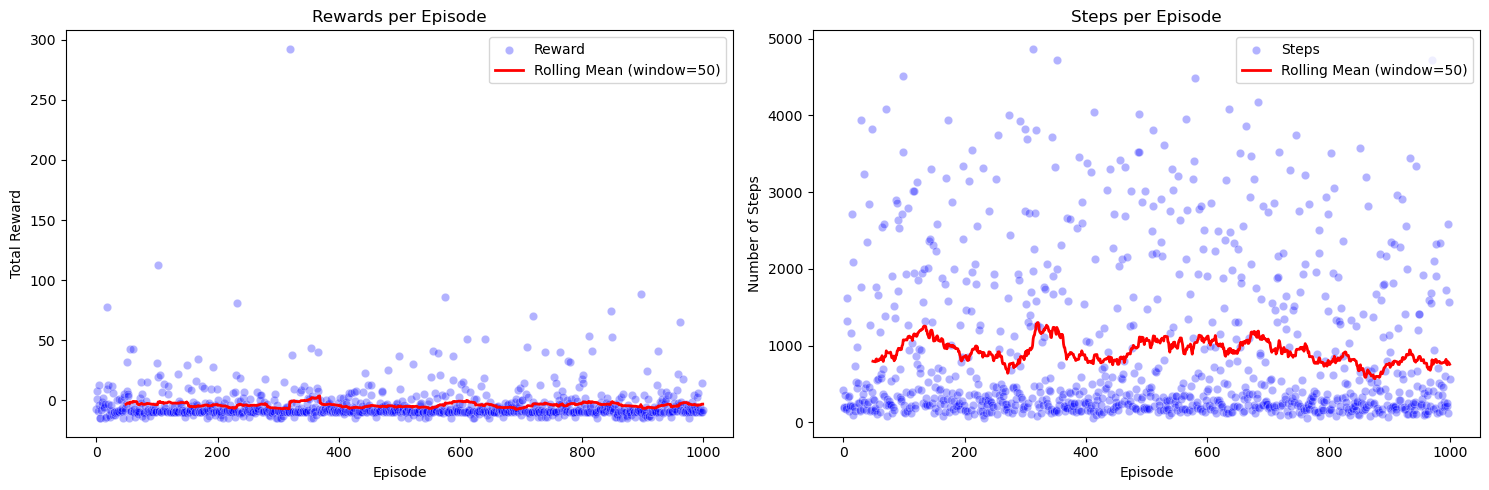

100%|██████████| 1000/1000 [00:43<00:00, 23.14it/s]
c:\Users\Don\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Don\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Don\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Don\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

At iteration 2
State-size = 593
Sum of total rewards = -3228.4999999999995
Average total reward per episode = -3.2285
Average steps per episode = 888.787


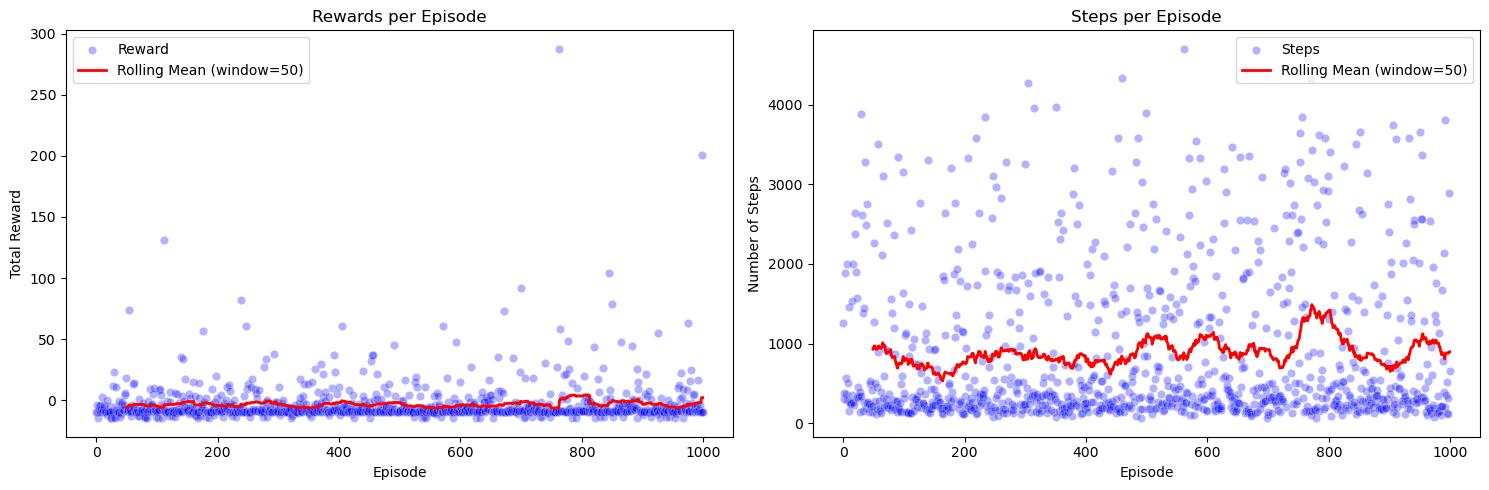

100%|██████████| 1000/1000 [00:45<00:00, 22.04it/s]
c:\Users\Don\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Don\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Don\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Don\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

At iteration 3
State-size = 585
Sum of total rewards = -3923.2999999999965
Average total reward per episode = -3.9233000000000002
Average steps per episode = 938.89


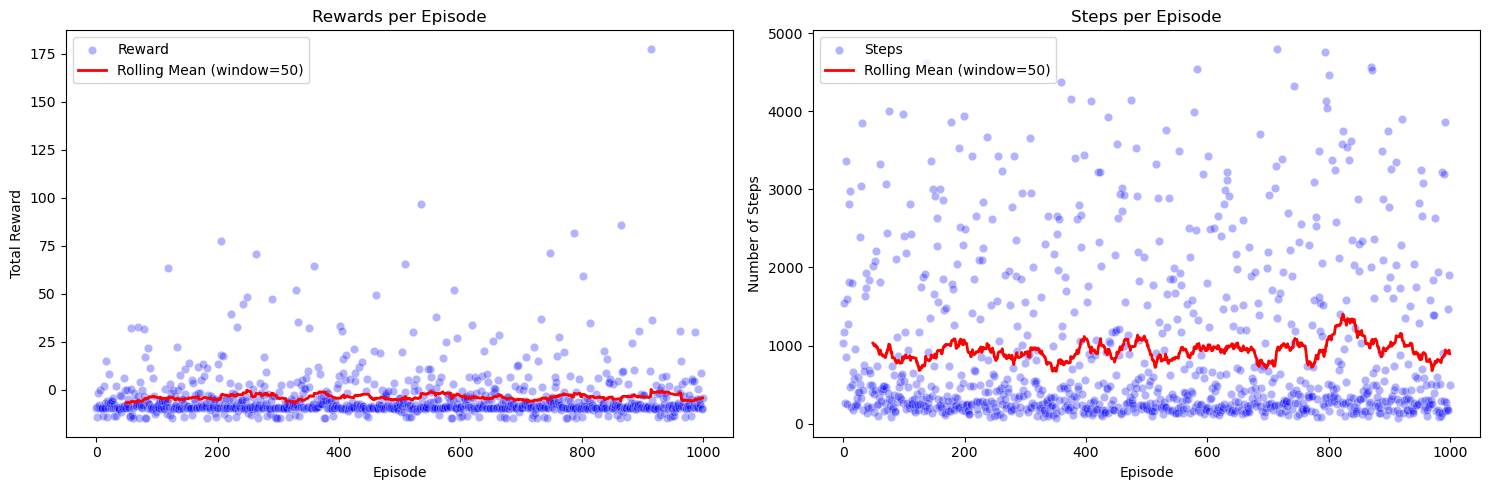


Average result per iteration
Sum of total rewards = -3651.833333333332
Average total reward per episode = -3.6518333333333337
Average steps per episode = 913.822


([-3803.6999999999994, -3228.4999999999995, -3923.2999999999965],
 [-3.8037, -3.2285, -3.9233000000000002],
 [913.789, 888.787, 938.89])

In [21]:
# SARSA
train_model(num_iterations = 3, num_episodes = 1000, on_policy = True, alpha=0.1, epsilon=0.1, lambd=0, gamma=0.9, save_model = True)

Action Distribution:
Left:   130 (21.8%)
Stay:   304 (51.1%)
Right:  161 (27.1%)


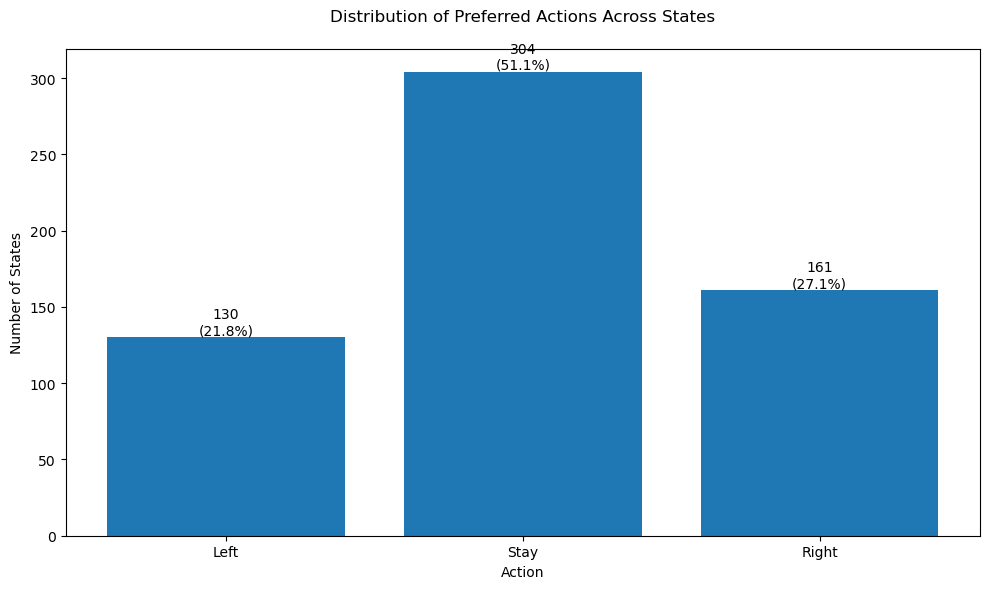

(130, 304, 161, 21.84873949579832, 51.09243697478991, 27.058823529411764)

In [27]:
analyze_model_actions(model_path="./logs/td/tdagent_20241105_211947/model_iteration_1.json")


In [ ]:
# SARSA
train_model(num_iterations = 3, num_episodes = 5000, on_policy = True, alpha=0.1, epsilon=0.1, lambd=0, gamma=0.9)

In [ ]:
# SARSA
train_model(num_iterations = 3, num_episodes = 10000, on_policy = True, alpha=0.1, epsilon=0.1, lambd=0, gamma=0.9)

In [ ]:
# SARSA with only 5 distance states
train_model(num_iterations = 3, num_episodes = 10000, on_policy = True, alpha=0.1, epsilon=0.1, lambd=0, gamma=0.9)

#### Search alpha & gamma

##### SARSA

In [ ]:
# SARSA
alpha_values = [0.1, 0.05, 0.01]
gamma_values = [0.9, 0.95, 0.99]
for alpha in alpha_values:
    for gamma in gamma_values:
        print(f'\n\n--------------------Hyperparameters alpha = {alpha}, gamma = {gamma}--------------------')
        train_model(num_iterations = 1, num_episodes = 5000, on_policy = True, alpha=alpha, epsilon=0.1, lambd=0, gamma=gamma) 

##### Q learning

In [ ]:
# Q-learning
alpha_values = [0.1, 0.05, 0.01]
gamma_values = [0.9, 0.95, 0.99]
for alpha in alpha_values:
    for gamma in gamma_values:
        print(f'\n--------------------Hyperparameters alpha = {alpha}, gamma = {gamma}--------------------')
        train_model(num_iterations = 1, num_episodes = 1000, on_policy = False, alpha=alpha, epsilon=0.1, lambd=0, gamma=gamma) 

##### Monte Carlo

In [ ]:
# MC with SARSA
alpha_values = [0.1, 0.05, 0.01]
gamma_values = [0.9, 0.95, 0.99]
for alpha in alpha_values:
    for gamma in gamma_values:
        print(f'\n--------------------Hyperparameters alpha = {alpha}, gamma = {gamma}--------------------')
        train_model(num_iterations = 1, num_episodes = 1000, on_policy = True, alpha=alpha, epsilon=0.1, lambd=1, gamma=gamma) 

In [ ]:
# MC with Q-learning
alpha_values = [0.1, 0.05, 0.01]
gamma_values = [0.9, 0.95, 0.99]
for alpha in alpha_values:
    for gamma in gamma_values:
        print(f'\n--------------------Hyperparameters alpha = {alpha}, gamma = {gamma}--------------------')
        train_model(num_iterations = 1, num_episodes = 1000, on_policy = False, alpha=alpha, epsilon=0.1, lambd=1, gamma=gamma) 

##### TD(lambda)

In [ ]:
# TD(lambda)
lambd_values = [0.5, 0.8]
alpha = 0.1
gamma = 0.9
for lambd in lambd_values:
    print(f'\n--------------------Hyperparameters alpha = {alpha}, gamma = {gamma}, lambda = {lambd} --------------------')
    train_model(num_iterations = 1, num_episodes = 10000, on_policy = False, alpha=alpha, epsilon=0.1, lambd=lambd, gamma=gamma) 